In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
ls 'drive/MyDrive/AIHealthcare/FER-master'

 bottleneck_features.npz                markdown/
 bottleneck_features_X.npz              npdata/
 dataset/                               np_test_files_list.npy
 Deep_Neural_Nets.ipynb                 np_train_files_list.npy
'FER Capstone Implementation.html'      plot_learning_curve.py
'FER Capstone Implementation.ipynb'     pre_dataset/
'FER Capstone Proposal.md'              README.md
'FER Capstone Proposal.pdf'             saved_models/
 haarcascades/                          shape_predictor_68_face_landmarks.dat
 install_env.sh                         source_emotion/
'Karthik - FER Capstone Report.html'    source_images/
'Karthik - FER Capstone Report.ipynb'   SVM_model.pkl
'Karthik - FER Capstone Report.pdf'


In [10]:
%cd drive/MyDrive/AIHealthcare/FER-master

/content/drive/MyDrive/AIHealthcare/FER-master


In [11]:
import keras
from keras import backend as K
from keras.preprocessing import image
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                        
%matplotlib inline
emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]

In [12]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [13]:
train_df = pd.DataFrame(np.load('npdata/np_train_files_list.npy',allow_pickle=True).tolist())
test_df = pd.DataFrame(np.load('npdata/np_test_files_list.npy',allow_pickle=True).tolist())

In [44]:
from sklearn.utils import shuffle
shuffled_df = shuffle(train_df).reset_index(drop=True)
shuffled_df.head()

,name,emotion
0,dataset/happy\14.png,5
1,dataset/contempt\1.png,2
2,dataset/happy\26.png,5
3,dataset/surprise\44.png,7
4,dataset/surprise\74.png,7


In [45]:
shuffled_df['name']=shuffled_df.apply(lambda x: x['name'].replace("\\", "/"),axis=1)

In [46]:
shuffled_df.head()

,name,emotion
0,dataset/happy/14.png,5
1,dataset/contempt/1.png,2
2,dataset/happy/26.png,5
3,dataset/surprise/44.png,7
4,dataset/surprise/74.png,7


In [47]:
# 80 % trainset, 20% valid set and the test_df will be the test set.
train_set_df = shuffled_df.iloc[:int(.8*len(shuffled_df))]
valid_set_df = shuffled_df.iloc[int(.8*len(shuffled_df)):]

In [48]:
def load_dataset(data):
    image_files = np.array(data['name'])
    emotion_class = np.array(data['emotion'])
    return image_files, emotion_class

In [60]:
test_df.head(5)

,name,emotion
0,dataset/neutral/85.png,0
1,dataset/neutral/20.png,0
2,dataset/neutral/73.png,0
3,dataset/neutral/88.png,0
4,dataset/neutral/89.png,0


In [59]:
test_df['name']=test_df.apply(lambda x: x['name'].replace("\\", "/"),axis=1)

In [62]:
# load train, test, and validation datasets
train_files, train_targets = load_dataset(train_set_df)
valid_files, valid_targets = load_dataset(valid_set_df)
test_files, test_targets = load_dataset(test_df)


# print statistics about the dataset
print('There are %s total emotion  files.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training emotion images.' % len(train_files))
print('There are %d validation emotion images.' % len(valid_files))
print('There are %d test emotion images.'% len(test_files))

There are 439 total emotion  files.

There are 283 training emotion images.
There are 71 validation emotion images.
There are 85 test emotion images.


In [50]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input as vgg_preprocess
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint

In [51]:

##### Convert images to tensors and create bottleneck features

def path_to_tensor(img_path, model=None, model_preprocess=None, transfer_learn=True):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(350, 350))
    
    # convert PIL.Image.Image type to 3D tensor with shape (350, 350)
    x = image.img_to_array(img)
    print('image.img_to_array(img) = ', x.shape)
    
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    x = np.expand_dims(x, axis=0)
    print('np.expand_dims = ', x.shape)
    
    # get the bottleneck feature from the model
    if transfer_learn and (model is not None) and (model_preprocess is not None):
        return model.predict(model_preprocess(x))
    else:
        return x    

def paths_to_tensor(img_paths, model, model_preprocess):
    list_of_tensors = [path_to_tensor(img_path, model, model_preprocess) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [52]:
model_VGG = VGG16(weights='imagenet', include_top=False)

In [53]:
ls 'dataset/surprise/47.png'

dataset/surprise/47.png


In [54]:
train_files

array(['dataset/happy/14.png', 'dataset/contempt/1.png',
       'dataset/happy/26.png', 'dataset/surprise/44.png',
       'dataset/surprise/74.png', 'dataset/anger/20.png',
       'dataset/surprise/57.png', 'dataset/contempt/15.png',
       'dataset/neutral/74.png', 'dataset/happy/31.png',
       'dataset/sadness/0.png', 'dataset/neutral/46.png',
       'dataset/anger/43.png', 'dataset/neutral/37.png',
       'dataset/surprise/0.png', 'dataset/neutral/33.png',
       'dataset/fear/6.png', 'dataset/surprise/59.png',
       'dataset/anger/44.png', 'dataset/happy/36.png',
       'dataset/neutral/110.png', 'dataset/neutral/29.png',
       'dataset/neutral/56.png', 'dataset/sadness/22.png',
       'dataset/sadness/24.png', 'dataset/sadness/16.png',
       'dataset/anger/1.png', 'dataset/surprise/68.png',
       'dataset/anger/31.png', 'dataset/happy/9.png',
       'dataset/sadness/9.png', 'dataset/disgust/26.png',
       'dataset/neutral/109.png', 'dataset/anger/16.png',
       'dataset/neu

In [63]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

# train_tensors_VGG_bottleneck = paths_to_tensor(train_files, model_VGG, vgg_preprocess)
# valid_tensors_VGG_bottleneck = paths_to_tensor(valid_files, model_VGG, vgg_preprocess)
test_tensors_VGG_bottleneck = paths_to_tensor(test_files, model_VGG, vgg_preprocess)










  0%|          | 0/85 [00:00<?, ?it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  1%|          | 1/85 [00:01<01:40,  1.19s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  2%|▏         | 2/85 [00:02<01:43,  1.25s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  4%|▎         | 3/85 [00:03<01:41,  1.24s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  5%|▍         | 4/85 [00:05<01:42,  1.27s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  6%|▌         | 5/85 [00:06<01:36,  1.21s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  7%|▋         | 6/85 [00:07<01:30,  1.15s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  8%|▊         | 7/85 [00:08<01:30,  1.16s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  9%|▉         | 8/85 [00:09<01:34,  1.22s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 11%|█         | 9/85 [00:10<01:31,  1.20s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 12%|█▏        | 10/85 [00:12<01:35,  1.28s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 13%|█▎        | 11/85 [00:13<01:37,  1.32s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 14%|█▍        | 12/85 [00:14<01:30,  1.24s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 15%|█▌        | 13/85 [00:16<01:30,  1.26s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 16%|█▋        | 14/85 [00:17<01:26,  1.22s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 18%|█▊        | 15/85 [00:18<01:28,  1.26s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 19%|█▉        | 16/85 [00:19<01:23,  1.22s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 20%|██        | 17/85 [00:21<01:26,  1.27s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 21%|██        | 18/85 [00:22<01:28,  1.32s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 22%|██▏       | 19/85 [00:23<01:23,  1.26s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 24%|██▎       | 20/85 [00:25<01:23,  1.28s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 25%|██▍       | 21/85 [00:26<01:19,  1.24s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 26%|██▌       | 22/85 [00:27<01:21,  1.30s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 27%|██▋       | 23/85 [00:28<01:20,  1.30s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 28%|██▊       | 24/85 [00:30<01:19,  1.31s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 29%|██▉       | 25/85 [00:31<01:16,  1.27s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 31%|███       | 26/85 [00:32<01:11,  1.21s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 32%|███▏      | 27/85 [00:33<01:14,  1.28s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 33%|███▎      | 28/85 [00:35<01:11,  1.25s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 34%|███▍      | 29/85 [00:36<01:07,  1.21s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 35%|███▌      | 30/85 [00:37<01:06,  1.21s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 36%|███▋      | 31/85 [00:38<01:02,  1.15s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 38%|███▊      | 32/85 [00:39<01:01,  1.16s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 39%|███▉      | 33/85 [00:40<01:00,  1.17s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 40%|████      | 34/85 [00:42<00:59,  1.17s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 41%|████      | 35/85 [00:43<00:55,  1.12s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 42%|████▏     | 36/85 [00:44<00:54,  1.11s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 44%|████▎     | 37/85 [00:45<00:51,  1.08s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 45%|████▍     | 38/85 [00:46<00:49,  1.05s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 46%|████▌     | 39/85 [00:47<00:47,  1.04s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 47%|████▋     | 40/85 [00:48<00:46,  1.03s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 48%|████▊     | 41/85 [00:49<00:46,  1.05s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 49%|████▉     | 42/85 [00:50<00:46,  1.09s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 51%|█████     | 43/85 [00:51<00:44,  1.05s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 52%|█████▏    | 44/85 [00:52<00:42,  1.03s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 53%|█████▎    | 45/85 [00:53<00:40,  1.01s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 54%|█████▍    | 46/85 [00:54<00:40,  1.05s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 55%|█████▌    | 47/85 [00:55<00:38,  1.02s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 56%|█████▋    | 48/85 [00:56<00:38,  1.05s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 58%|█████▊    | 49/85 [00:57<00:37,  1.03s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 59%|█████▉    | 50/85 [00:58<00:36,  1.05s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 60%|██████    | 51/85 [00:59<00:36,  1.06s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 61%|██████    | 52/85 [01:00<00:34,  1.05s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 62%|██████▏   | 53/85 [01:01<00:32,  1.02s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 64%|██████▎   | 54/85 [01:02<00:32,  1.06s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 65%|██████▍   | 55/85 [01:03<00:30,  1.03s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 66%|██████▌   | 56/85 [01:04<00:31,  1.07s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 67%|██████▋   | 57/85 [01:05<00:29,  1.04s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 68%|██████▊   | 58/85 [01:06<00:27,  1.03s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 69%|██████▉   | 59/85 [01:07<00:26,  1.02s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 71%|███████   | 60/85 [01:08<00:25,  1.00s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 72%|███████▏  | 61/85 [01:09<00:23,  1.01it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 73%|███████▎  | 62/85 [01:10<00:23,  1.01s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 74%|███████▍  | 63/85 [01:11<00:22,  1.00s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 75%|███████▌  | 64/85 [01:13<00:22,  1.08s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 76%|███████▋  | 65/85 [01:14<00:20,  1.05s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 78%|███████▊  | 66/85 [01:15<00:19,  1.03s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 79%|███████▉  | 67/85 [01:16<00:18,  1.02s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 80%|████████  | 68/85 [01:17<00:17,  1.01s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 81%|████████  | 69/85 [01:18<00:16,  1.00s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 82%|████████▏ | 70/85 [01:19<00:15,  1.03s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 84%|████████▎ | 71/85 [01:20<00:14,  1.02s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 85%|████████▍ | 72/85 [01:21<00:13,  1.01s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 86%|████████▌ | 73/85 [01:22<00:12,  1.00s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 87%|████████▋ | 74/85 [01:23<00:11,  1.04s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 88%|████████▊ | 75/85 [01:24<00:10,  1.02s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 89%|████████▉ | 76/85 [01:25<00:09,  1.01s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 91%|█████████ | 77/85 [01:26<00:07,  1.00it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 92%|█████████▏| 78/85 [01:27<00:06,  1.01it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 93%|█████████▎| 79/85 [01:28<00:05,  1.01it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 94%|█████████▍| 80/85 [01:29<00:04,  1.00it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 95%|█████████▌| 81/85 [01:30<00:03,  1.00it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 96%|█████████▋| 82/85 [01:31<00:03,  1.02s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 98%|█████████▊| 83/85 [01:32<00:02,  1.00s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 99%|█████████▉| 84/85 [01:33<00:01,  1.08s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











100%|██████████| 85/85 [01:34<00:00,  1.11s/it]


In [64]:
np.savez("bottleneck_features.npz", train=train_tensors_VGG_bottleneck, valid=valid_tensors_VGG_bottleneck, test=test_tensors_VGG_bottleneck)

In [65]:
npzfile = np.load("bottleneck_features.npz")
npzfile.files

['train', 'valid', 'test']

In [66]:
print('Training: ',train_tensors_VGG_bottleneck.shape)
print('Validation: ',valid_tensors_VGG_bottleneck.shape)
print('Test: ',test_tensors_VGG_bottleneck.shape)

Training:  (283, 10, 10, 512)
Validation:  (71, 10, 10, 512)
Test:  (85, 10, 10, 512)


In [67]:
from keras.utils import np_utils
num_classes = len(emotions)
y_train = train_set_df.emotion
y_train = np_utils.to_categorical(y_train, num_classes)

y_valid = valid_set_df.emotion
y_valid = np_utils.to_categorical(y_valid, num_classes)

y_test = test_df.emotion
y_test = np_utils.to_categorical(y_test, num_classes)

print('Training: ',y_train.shape)
print('Validation: ',y_valid.shape)
print('Test: ',y_test.shape)

Training:  (283, 8)
Validation:  (71, 8)
Test:  (85, 8)


In [68]:
train_VGG16 = npzfile["train"]
valid_VGG16 = npzfile["valid"]
test_VGG16 = npzfile["test"]

In [69]:
print(train_VGG16.shape[1:])

(10, 10, 512)


In [70]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(len(emotions), activation='softmax'))

VGG16_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 4104      
Total params: 4,104
Trainable params: 4,104
Non-trainable params: 0
_________________________________________________________________


In [71]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [72]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5',
                               verbose=1, save_best_only=True)

VGG16_history = VGG16_model.fit(train_VGG16, y_train,
          validation_data=(valid_VGG16, y_valid),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
15/15 [==============================] - 1s 18ms/step - loss: 4.3115 - accuracy: 0.2221 - val_loss: 2.8280 - val_accuracy: 0.1408

Epoch 00001: val_loss improved from inf to 2.82798, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
15/15 [==============================] - 0s 6ms/step - loss: 2.4185 - accuracy: 0.2508 - val_loss: 2.3053 - val_accuracy: 0.2676

Epoch 00002: val_loss improved from 2.82798 to 2.30526, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
15/15 [==============================] - 0s 6ms/step - loss: 1.9096 - accuracy: 0.3452 - val_loss: 1.9203 - val_accuracy: 0.2535

Epoch 00003: val_loss improved from 2.30526 to 1.92029, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
15/15 [==============================] - 0s 5ms/step - loss: 1.5518 - accuracy: 0.4669 - val_loss: 1.6989 - val_accuracy: 0.3521

Epoch 00004: val_loss improved from 1.92029 to 1.69894, saving model to saved_models/weights.best.VGG16.hdf5
Epo

In [73]:
def plot_accuracy_loss_for_train_valid(model, title, epoch_len=21, epoch_window=5):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epoch_len))
    ax1.plot(epoch_list, model.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, model.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epoch_len, epoch_window))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, model.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, model.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epoch_len, epoch_window))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

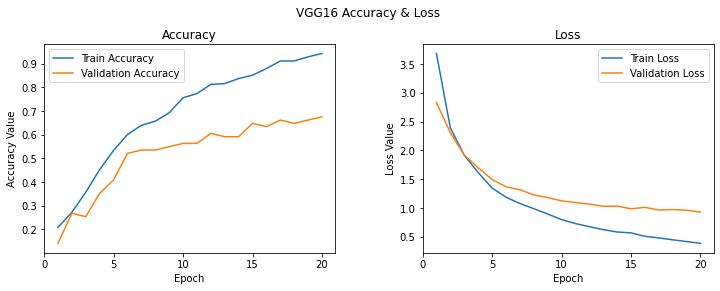

In [74]:
plot_accuracy_loss_for_train_valid(VGG16_history, "VGG16 Accuracy & Loss")

In [75]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [76]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(y_test, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 71.7647%


In [77]:
VGG16_test_score = VGG16_model.evaluate(test_VGG16,y_test)
print("Log loss of the VGG16 model is {0}".format(VGG16_test_score[0]))

3/3 [==============================] - 0s 5ms/step - loss: 0.7815 - accuracy: 0.7176
Log loss of the VGG16 model is 0.7815175652503967


Normalized confusion matrix


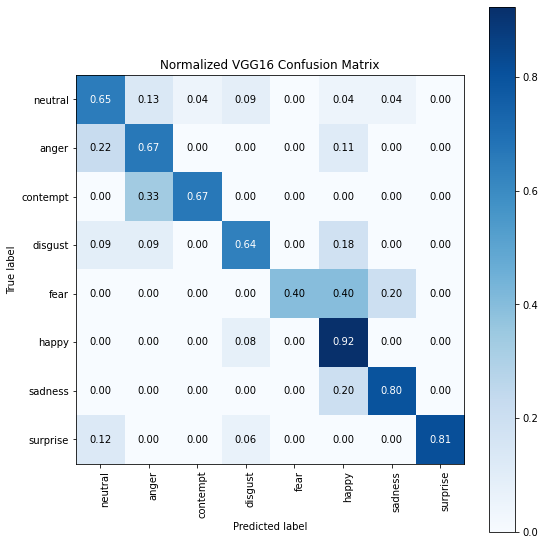

In [78]:
plot_confusion_matrix(test_df.emotion, VGG16_predictions, classes=emotions, normalize=True,
                      title='Normalized VGG16 Confusion Matrix')

plt.show()

Build Transfer learned Xception

In [79]:
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess
model_Xception = Xception(weights='imagenet', include_top=False)

83689472/83683744 [==============================] - 1s 0us/step


In [80]:
train_tensors_X_bottleneck = paths_to_tensor(train_files, model_Xception, xception_preprocess)
valid_tensors_X_bottleneck = paths_to_tensor(valid_files, model_Xception, xception_preprocess)
test_tensors_X_bottleneck = paths_to_tensor(test_files, model_Xception, xception_preprocess)










  0%|          | 0/283 [00:00<?, ?it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  0%|          | 1/283 [00:01<08:41,  1.85s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  1%|          | 2/283 [00:02<07:05,  1.51s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  1%|          | 3/283 [00:03<06:01,  1.29s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  1%|▏         | 4/283 [00:04<05:30,  1.18s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  2%|▏         | 5/283 [00:05<05:03,  1.09s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  2%|▏         | 6/283 [00:05<04:37,  1.00s/it]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  2%|▏         | 7/283 [00:06<04:06,  1.12it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  3%|▎         | 8/283 [00:07<03:45,  1.22it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  3%|▎         | 9/283 [00:08<03:40,  1.24it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  4%|▎         | 10/283 [00:08<03:33,  1.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  4%|▍         | 11/283 [00:09<03:27,  1.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  4%|▍         | 12/283 [00:10<03:33,  1.27it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  5%|▍         | 13/283 [00:11<03:26,  1.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  5%|▍         | 14/283 [00:12<03:47,  1.18it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  5%|▌         | 15/283 [00:12<03:49,  1.17it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  6%|▌         | 16/283 [00:13<03:40,  1.21it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  6%|▌         | 17/283 [00:14<03:57,  1.12it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  6%|▋         | 18/283 [00:15<03:46,  1.17it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  7%|▋         | 19/283 [00:16<03:32,  1.24it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  7%|▋         | 20/283 [00:16<03:28,  1.26it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  7%|▋         | 21/283 [00:17<03:27,  1.26it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  8%|▊         | 22/283 [00:18<03:29,  1.24it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  8%|▊         | 23/283 [00:19<03:17,  1.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  8%|▊         | 24/283 [00:19<03:12,  1.35it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  9%|▉         | 25/283 [00:20<03:21,  1.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  9%|▉         | 26/283 [00:21<03:21,  1.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 10%|▉         | 27/283 [00:22<03:09,  1.35it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 10%|▉         | 28/283 [00:22<03:02,  1.40it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 10%|█         | 29/283 [00:23<02:56,  1.44it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 11%|█         | 30/283 [00:24<02:52,  1.47it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 11%|█         | 31/283 [00:24<02:50,  1.48it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 11%|█▏        | 32/283 [00:25<02:48,  1.49it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 12%|█▏        | 33/283 [00:26<02:56,  1.42it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 12%|█▏        | 34/283 [00:27<03:05,  1.35it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 12%|█▏        | 35/283 [00:27<03:11,  1.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 13%|█▎        | 36/283 [00:28<03:01,  1.36it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 13%|█▎        | 37/283 [00:29<02:59,  1.37it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 13%|█▎        | 38/283 [00:30<03:06,  1.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 14%|█▍        | 39/283 [00:30<02:55,  1.39it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 14%|█▍        | 40/283 [00:31<02:49,  1.43it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 14%|█▍        | 41/283 [00:32<02:48,  1.44it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 15%|█▍        | 42/283 [00:33<03:09,  1.27it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 15%|█▌        | 43/283 [00:33<02:59,  1.33it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 16%|█▌        | 44/283 [00:34<03:04,  1.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 16%|█▌        | 45/283 [00:35<02:54,  1.37it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 16%|█▋        | 46/283 [00:35<02:46,  1.43it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 17%|█▋        | 47/283 [00:36<02:53,  1.36it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 17%|█▋        | 48/283 [00:37<02:49,  1.39it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 17%|█▋        | 49/283 [00:38<02:43,  1.43it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 18%|█▊        | 50/283 [00:38<02:39,  1.46it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 18%|█▊        | 51/283 [00:39<02:35,  1.50it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 18%|█▊        | 52/283 [00:40<02:47,  1.38it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 19%|█▊        | 53/283 [00:40<02:40,  1.43it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 19%|█▉        | 54/283 [00:41<02:37,  1.45it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 19%|█▉        | 55/283 [00:42<02:35,  1.46it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 20%|█▉        | 56/283 [00:42<02:40,  1.41it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 20%|██        | 57/283 [00:43<02:44,  1.37it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 20%|██        | 58/283 [00:44<02:37,  1.43it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 21%|██        | 59/283 [00:44<02:32,  1.46it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 21%|██        | 60/283 [00:45<02:39,  1.40it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 22%|██▏       | 61/283 [00:46<02:34,  1.44it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 22%|██▏       | 62/283 [00:47<02:39,  1.39it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 22%|██▏       | 63/283 [00:47<02:33,  1.43it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 23%|██▎       | 64/283 [00:48<02:40,  1.37it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 23%|██▎       | 65/283 [00:49<02:34,  1.42it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 23%|██▎       | 66/283 [00:50<02:36,  1.39it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 24%|██▎       | 67/283 [00:50<02:16,  1.58it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 24%|██▍       | 68/283 [00:51<02:30,  1.43it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 24%|██▍       | 69/283 [00:52<02:52,  1.24it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 25%|██▍       | 70/283 [00:53<02:41,  1.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 25%|██▌       | 71/283 [00:53<02:35,  1.36it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 25%|██▌       | 72/283 [00:54<02:42,  1.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 26%|██▌       | 73/283 [00:55<02:44,  1.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 26%|██▌       | 74/283 [00:55<02:21,  1.48it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 27%|██▋       | 75/283 [00:56<02:18,  1.51it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 27%|██▋       | 76/283 [00:57<02:23,  1.45it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 27%|██▋       | 77/283 [00:57<02:20,  1.47it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 28%|██▊       | 78/283 [00:58<02:27,  1.39it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 28%|██▊       | 79/283 [00:59<02:21,  1.44it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 28%|██▊       | 80/283 [00:59<02:20,  1.45it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 29%|██▊       | 81/283 [01:00<02:17,  1.47it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 29%|██▉       | 82/283 [01:01<02:13,  1.50it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 29%|██▉       | 83/283 [01:01<02:11,  1.52it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 30%|██▉       | 84/283 [01:02<01:56,  1.71it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 30%|███       | 85/283 [01:02<02:01,  1.63it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 30%|███       | 86/283 [01:03<02:05,  1.57it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 31%|███       | 87/283 [01:04<02:04,  1.57it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 31%|███       | 88/283 [01:05<02:10,  1.49it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 31%|███▏      | 89/283 [01:05<02:10,  1.49it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 32%|███▏      | 90/283 [01:06<02:07,  1.52it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 32%|███▏      | 91/283 [01:07<02:14,  1.43it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 33%|███▎      | 92/283 [01:07<01:57,  1.63it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 33%|███▎      | 93/283 [01:08<01:58,  1.60it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 33%|███▎      | 94/283 [01:08<01:58,  1.59it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 34%|███▎      | 95/283 [01:09<02:00,  1.56it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 34%|███▍      | 96/283 [01:10<02:00,  1.55it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 34%|███▍      | 97/283 [01:10<02:00,  1.54it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 35%|███▍      | 98/283 [01:11<02:02,  1.51it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 35%|███▍      | 99/283 [01:12<02:00,  1.52it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 35%|███▌      | 100/283 [01:12<02:02,  1.50it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 36%|███▌      | 101/283 [01:13<01:47,  1.69it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 36%|███▌      | 102/283 [01:13<01:52,  1.61it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 36%|███▋      | 103/283 [01:14<02:05,  1.43it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 37%|███▋      | 104/283 [01:15<02:02,  1.46it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 37%|███▋      | 105/283 [01:16<02:01,  1.47it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 37%|███▋      | 106/283 [01:16<01:59,  1.48it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 38%|███▊      | 107/283 [01:17<01:45,  1.67it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 38%|███▊      | 108/283 [01:17<01:48,  1.62it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 39%|███▊      | 109/283 [01:18<01:37,  1.79it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 39%|███▉      | 110/283 [01:19<01:49,  1.58it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 39%|███▉      | 111/283 [01:19<01:38,  1.74it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 40%|███▉      | 112/283 [01:20<01:57,  1.46it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 40%|███▉      | 113/283 [01:21<01:54,  1.49it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 40%|████      | 114/283 [01:21<01:53,  1.49it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 41%|████      | 115/283 [01:22<01:59,  1.41it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 41%|████      | 116/283 [01:23<01:56,  1.43it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 41%|████▏     | 117/283 [01:24<01:54,  1.44it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 42%|████▏     | 118/283 [01:24<01:57,  1.41it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 42%|████▏     | 119/283 [01:25<01:52,  1.45it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 42%|████▏     | 120/283 [01:26<01:51,  1.46it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 43%|████▎     | 121/283 [01:26<01:49,  1.48it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 43%|████▎     | 122/283 [01:27<01:36,  1.66it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 43%|████▎     | 123/283 [01:27<01:38,  1.62it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 44%|████▍     | 124/283 [01:28<01:39,  1.59it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 44%|████▍     | 125/283 [01:28<01:29,  1.77it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 45%|████▍     | 126/283 [01:29<01:32,  1.70it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 45%|████▍     | 127/283 [01:30<01:35,  1.64it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 45%|████▌     | 128/283 [01:30<01:25,  1.81it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 46%|████▌     | 129/283 [01:31<01:30,  1.70it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 46%|████▌     | 130/283 [01:31<01:33,  1.63it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 46%|████▋     | 131/283 [01:32<01:35,  1.59it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 47%|████▋     | 132/283 [01:33<01:40,  1.50it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 47%|████▋     | 133/283 [01:34<01:45,  1.42it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 47%|████▋     | 134/283 [01:34<01:43,  1.44it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 48%|████▊     | 135/283 [01:35<01:40,  1.47it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 48%|████▊     | 136/283 [01:36<01:41,  1.45it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 48%|████▊     | 137/283 [01:36<01:28,  1.64it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 49%|████▉     | 138/283 [01:37<01:43,  1.40it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 49%|████▉     | 139/283 [01:38<01:39,  1.45it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 49%|████▉     | 140/283 [01:38<01:42,  1.40it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 50%|████▉     | 141/283 [01:39<01:40,  1.41it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 50%|█████     | 142/283 [01:40<01:37,  1.44it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 51%|█████     | 143/283 [01:41<01:45,  1.33it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 51%|█████     | 144/283 [01:42<01:46,  1.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 51%|█████     | 145/283 [01:42<01:43,  1.34it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 52%|█████▏    | 146/283 [01:43<01:42,  1.34it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 52%|█████▏    | 147/283 [01:44<01:37,  1.40it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 52%|█████▏    | 148/283 [01:45<01:46,  1.26it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 53%|█████▎    | 149/283 [01:45<01:41,  1.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 53%|█████▎    | 150/283 [01:46<01:27,  1.53it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 53%|█████▎    | 151/283 [01:46<01:17,  1.71it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 54%|█████▎    | 152/283 [01:47<01:10,  1.87it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 54%|█████▍    | 153/283 [01:47<01:06,  1.97it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 54%|█████▍    | 154/283 [01:48<01:16,  1.69it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 55%|█████▍    | 155/283 [01:48<01:17,  1.66it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 55%|█████▌    | 156/283 [01:49<01:18,  1.62it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 55%|█████▌    | 157/283 [01:50<01:25,  1.48it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 56%|█████▌    | 158/283 [01:51<01:28,  1.42it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 56%|█████▌    | 159/283 [01:52<01:38,  1.26it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 57%|█████▋    | 160/283 [01:52<01:33,  1.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 57%|█████▋    | 161/283 [01:53<01:28,  1.37it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 57%|█████▋    | 162/283 [01:54<01:27,  1.38it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 58%|█████▊    | 163/283 [01:55<01:32,  1.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 58%|█████▊    | 164/283 [01:55<01:20,  1.48it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 58%|█████▊    | 165/283 [01:56<01:19,  1.48it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 59%|█████▊    | 166/283 [01:56<01:18,  1.49it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 59%|█████▉    | 167/283 [01:57<01:17,  1.51it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 59%|█████▉    | 168/283 [01:57<01:08,  1.69it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 60%|█████▉    | 169/283 [01:58<01:14,  1.53it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 60%|██████    | 170/283 [01:59<01:14,  1.52it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 60%|██████    | 171/283 [02:00<01:15,  1.49it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 61%|██████    | 172/283 [02:00<01:06,  1.66it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 61%|██████    | 173/283 [02:01<01:13,  1.50it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 61%|██████▏   | 174/283 [02:01<01:12,  1.51it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 62%|██████▏   | 175/283 [02:02<01:11,  1.51it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 62%|██████▏   | 176/283 [02:03<01:10,  1.51it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 63%|██████▎   | 177/283 [02:03<01:09,  1.52it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 63%|██████▎   | 178/283 [02:04<01:11,  1.47it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 63%|██████▎   | 179/283 [02:05<01:02,  1.66it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 64%|██████▎   | 180/283 [02:05<01:03,  1.62it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 64%|██████▍   | 181/283 [02:06<01:04,  1.59it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 64%|██████▍   | 182/283 [02:07<01:05,  1.53it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 65%|██████▍   | 183/283 [02:07<01:05,  1.53it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 65%|██████▌   | 184/283 [02:08<01:04,  1.53it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 65%|██████▌   | 185/283 [02:09<01:03,  1.55it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 66%|██████▌   | 186/283 [02:09<01:02,  1.54it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 66%|██████▌   | 187/283 [02:10<00:56,  1.71it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 66%|██████▋   | 188/283 [02:10<00:58,  1.64it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 67%|██████▋   | 189/283 [02:11<00:58,  1.61it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 67%|██████▋   | 190/283 [02:12<01:04,  1.45it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 67%|██████▋   | 191/283 [02:13<01:03,  1.44it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 68%|██████▊   | 192/283 [02:13<00:55,  1.63it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 68%|██████▊   | 193/283 [02:14<00:59,  1.51it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 69%|██████▊   | 194/283 [02:14<00:58,  1.52it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 69%|██████▉   | 195/283 [02:15<00:58,  1.50it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 69%|██████▉   | 196/283 [02:16<01:01,  1.43it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 70%|██████▉   | 197/283 [02:17<01:24,  1.01it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 70%|██████▉   | 198/283 [02:18<01:17,  1.10it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 70%|███████   | 199/283 [02:19<01:10,  1.20it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 71%|███████   | 200/283 [02:20<01:04,  1.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 71%|███████   | 201/283 [02:20<01:00,  1.36it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 71%|███████▏  | 202/283 [02:21<00:52,  1.55it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 72%|███████▏  | 203/283 [02:21<00:52,  1.52it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 72%|███████▏  | 204/283 [02:22<00:51,  1.52it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 72%|███████▏  | 205/283 [02:23<00:50,  1.53it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 73%|███████▎  | 206/283 [02:23<00:51,  1.50it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 73%|███████▎  | 207/283 [02:24<00:51,  1.49it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 73%|███████▎  | 208/283 [02:25<00:49,  1.51it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 74%|███████▍  | 209/283 [02:25<00:44,  1.68it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 74%|███████▍  | 210/283 [02:25<00:39,  1.83it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 75%|███████▍  | 211/283 [02:26<00:36,  1.96it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 75%|███████▍  | 212/283 [02:26<00:34,  2.07it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 75%|███████▌  | 213/283 [02:27<00:37,  1.86it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 76%|███████▌  | 214/283 [02:28<00:40,  1.72it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 76%|███████▌  | 215/283 [02:28<00:36,  1.86it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 76%|███████▋  | 216/283 [02:29<00:38,  1.75it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 77%|███████▋  | 217/283 [02:29<00:34,  1.89it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 77%|███████▋  | 218/283 [02:30<00:32,  2.01it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 77%|███████▋  | 219/283 [02:30<00:30,  2.09it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 78%|███████▊  | 220/283 [02:31<00:33,  1.86it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 78%|███████▊  | 221/283 [02:31<00:31,  1.97it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 78%|███████▊  | 222/283 [02:32<00:34,  1.78it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 79%|███████▉  | 223/283 [02:33<00:35,  1.68it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 79%|███████▉  | 224/283 [02:33<00:36,  1.62it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 80%|███████▉  | 225/283 [02:34<00:38,  1.52it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 80%|███████▉  | 226/283 [02:34<00:33,  1.71it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 80%|████████  | 227/283 [02:35<00:33,  1.67it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 81%|████████  | 228/283 [02:35<00:30,  1.81it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 81%|████████  | 229/283 [02:36<00:31,  1.72it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 81%|████████▏ | 230/283 [02:37<00:32,  1.61it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 82%|████████▏ | 231/283 [02:37<00:32,  1.58it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 82%|████████▏ | 232/283 [02:38<00:35,  1.42it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 82%|████████▏ | 233/283 [02:39<00:31,  1.60it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 83%|████████▎ | 234/283 [02:39<00:27,  1.76it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 83%|████████▎ | 235/283 [02:40<00:28,  1.69it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 83%|████████▎ | 236/283 [02:40<00:25,  1.84it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 84%|████████▎ | 237/283 [02:41<00:28,  1.63it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 84%|████████▍ | 238/283 [02:42<00:28,  1.59it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 84%|████████▍ | 239/283 [02:42<00:25,  1.75it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 85%|████████▍ | 240/283 [02:43<00:22,  1.88it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 85%|████████▌ | 241/283 [02:43<00:24,  1.70it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 86%|████████▌ | 242/283 [02:44<00:24,  1.65it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 86%|████████▌ | 243/283 [02:45<00:27,  1.46it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 86%|████████▌ | 244/283 [02:45<00:23,  1.63it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 87%|████████▋ | 245/283 [02:46<00:21,  1.79it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 87%|████████▋ | 246/283 [02:46<00:21,  1.70it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 87%|████████▋ | 247/283 [02:47<00:21,  1.64it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 88%|████████▊ | 248/283 [02:48<00:21,  1.61it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 88%|████████▊ | 249/283 [02:48<00:21,  1.59it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 88%|████████▊ | 250/283 [02:49<00:18,  1.75it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 89%|████████▊ | 251/283 [02:49<00:18,  1.69it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 89%|████████▉ | 252/283 [02:50<00:16,  1.84it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 89%|████████▉ | 253/283 [02:50<00:17,  1.73it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 90%|████████▉ | 254/283 [02:51<00:17,  1.65it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 90%|█████████ | 255/283 [02:52<00:18,  1.49it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 90%|█████████ | 256/283 [02:52<00:16,  1.67it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 91%|█████████ | 257/283 [02:53<00:14,  1.82it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 91%|█████████ | 258/283 [02:53<00:14,  1.73it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 92%|█████████▏| 259/283 [02:54<00:12,  1.87it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 92%|█████████▏| 260/283 [02:55<00:13,  1.76it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 92%|█████████▏| 261/283 [02:55<00:11,  1.90it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 93%|█████████▎| 262/283 [02:55<00:10,  2.01it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 93%|█████████▎| 263/283 [02:56<00:11,  1.78it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 93%|█████████▎| 264/283 [02:57<00:11,  1.60it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 94%|█████████▎| 265/283 [02:58<00:12,  1.47it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 94%|█████████▍| 266/283 [02:58<00:11,  1.47it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 94%|█████████▍| 267/283 [02:59<00:09,  1.65it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 95%|█████████▍| 268/283 [03:00<00:09,  1.59it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 95%|█████████▌| 269/283 [03:00<00:08,  1.57it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 95%|█████████▌| 270/283 [03:01<00:08,  1.57it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 96%|█████████▌| 271/283 [03:01<00:07,  1.56it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 96%|█████████▌| 272/283 [03:02<00:07,  1.55it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 96%|█████████▋| 273/283 [03:03<00:05,  1.73it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 97%|█████████▋| 274/283 [03:04<00:08,  1.12it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 97%|█████████▋| 275/283 [03:05<00:06,  1.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 98%|█████████▊| 276/283 [03:05<00:04,  1.50it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 98%|█████████▊| 277/283 [03:06<00:03,  1.66it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 98%|█████████▊| 278/283 [03:06<00:03,  1.60it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 99%|█████████▊| 279/283 [03:07<00:02,  1.58it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 99%|█████████▉| 280/283 [03:07<00:01,  1.73it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 99%|█████████▉| 281/283 [03:08<00:01,  1.63it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











100%|█████████▉| 282/283 [03:09<00:00,  1.51it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











100%|██████████| 283/283 [03:09<00:00,  1.49it/s]









  0%|          | 0/71 [00:00<?, ?it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  1%|▏         | 1/71 [00:00<00:46,  1.51it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  3%|▎         | 2/71 [00:01<00:46,  1.49it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  4%|▍         | 3/71 [00:02<00:48,  1.41it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  6%|▌         | 4/71 [00:02<00:48,  1.37it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  7%|▋         | 5/71 [00:03<00:46,  1.41it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  8%|▊         | 6/71 [00:04<00:40,  1.60it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 10%|▉         | 7/71 [00:04<00:36,  1.77it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 11%|█▏        | 8/71 [00:05<00:37,  1.66it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 13%|█▎        | 9/71 [00:05<00:38,  1.63it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 14%|█▍        | 10/71 [00:06<00:37,  1.61it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 15%|█▌        | 11/71 [00:07<00:38,  1.58it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 17%|█▋        | 12/71 [00:07<00:39,  1.49it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 18%|█▊        | 13/71 [00:08<00:38,  1.50it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 20%|█▉        | 14/71 [00:09<00:37,  1.53it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 21%|██        | 15/71 [00:09<00:36,  1.53it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 23%|██▎       | 16/71 [00:10<00:35,  1.55it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 24%|██▍       | 17/71 [00:11<00:36,  1.48it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 25%|██▌       | 18/71 [00:11<00:37,  1.40it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 27%|██▋       | 19/71 [00:12<00:36,  1.44it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 28%|██▊       | 20/71 [00:13<00:34,  1.46it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 30%|██▉       | 21/71 [00:13<00:30,  1.64it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 31%|███       | 22/71 [00:14<00:27,  1.81it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 32%|███▏      | 23/71 [00:14<00:24,  1.93it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 34%|███▍      | 24/71 [00:15<00:27,  1.71it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 35%|███▌      | 25/71 [00:16<00:29,  1.56it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 37%|███▋      | 26/71 [00:16<00:31,  1.42it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 38%|███▊      | 27/71 [00:17<00:27,  1.61it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 39%|███▉      | 28/71 [00:18<00:27,  1.58it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 41%|████      | 29/71 [00:18<00:24,  1.75it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 42%|████▏     | 30/71 [00:18<00:21,  1.88it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 44%|████▎     | 31/71 [00:19<00:20,  2.00it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 45%|████▌     | 32/71 [00:19<00:18,  2.09it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 46%|████▋     | 33/71 [00:20<00:17,  2.17it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 48%|████▊     | 34/71 [00:20<00:16,  2.22it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 49%|████▉     | 35/71 [00:21<00:19,  1.88it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 51%|█████     | 36/71 [00:21<00:17,  1.98it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 52%|█████▏    | 37/71 [00:22<00:16,  2.09it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 54%|█████▎    | 38/71 [00:22<00:15,  2.16it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 55%|█████▍    | 39/71 [00:23<00:19,  1.68it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 56%|█████▋    | 40/71 [00:23<00:16,  1.83it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 58%|█████▊    | 41/71 [00:24<00:17,  1.73it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 59%|█████▉    | 42/71 [00:25<00:17,  1.67it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 61%|██████    | 43/71 [00:25<00:15,  1.82it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 62%|██████▏   | 44/71 [00:26<00:16,  1.61it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 63%|██████▎   | 45/71 [00:26<00:14,  1.78it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 65%|██████▍   | 46/71 [00:27<00:13,  1.91it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 66%|██████▌   | 47/71 [00:27<00:11,  2.00it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 68%|██████▊   | 48/71 [00:28<00:12,  1.84it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 69%|██████▉   | 49/71 [00:28<00:11,  1.97it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 70%|███████   | 50/71 [00:29<00:10,  2.06it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 72%|███████▏  | 51/71 [00:29<00:09,  2.13it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 73%|███████▎  | 52/71 [00:30<00:08,  2.17it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 75%|███████▍  | 53/71 [00:30<00:09,  1.95it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 76%|███████▌  | 54/71 [00:31<00:08,  2.06it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 77%|███████▋  | 55/71 [00:31<00:08,  1.82it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 79%|███████▉  | 56/71 [00:32<00:09,  1.61it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 80%|████████  | 57/71 [00:33<00:07,  1.76it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 82%|████████▏ | 58/71 [00:33<00:06,  1.90it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 83%|████████▎ | 59/71 [00:34<00:06,  1.74it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 85%|████████▍ | 60/71 [00:34<00:07,  1.57it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 86%|████████▌ | 61/71 [00:35<00:05,  1.73it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 87%|████████▋ | 62/71 [00:36<00:05,  1.65it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 89%|████████▊ | 63/71 [00:36<00:04,  1.81it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 90%|█████████ | 64/71 [00:36<00:03,  1.94it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 92%|█████████▏| 65/71 [00:37<00:03,  1.75it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 93%|█████████▎| 66/71 [00:38<00:02,  1.88it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 94%|█████████▍| 67/71 [00:38<00:02,  1.75it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 96%|█████████▌| 68/71 [00:39<00:01,  1.88it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 97%|█████████▋| 69/71 [00:39<00:01,  2.00it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 99%|█████████▊| 70/71 [00:40<00:00,  2.09it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











100%|██████████| 71/71 [00:40<00:00,  1.74it/s]









  0%|          | 0/85 [00:00<?, ?it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  1%|          | 1/85 [00:00<00:36,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  2%|▏         | 2/85 [00:00<00:35,  2.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  4%|▎         | 3/85 [00:01<00:36,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  5%|▍         | 4/85 [00:01<00:35,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  6%|▌         | 5/85 [00:02<00:34,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  7%|▋         | 6/85 [00:02<00:34,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  8%|▊         | 7/85 [00:03<00:33,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  9%|▉         | 8/85 [00:03<00:33,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 11%|█         | 9/85 [00:03<00:32,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 12%|█▏        | 10/85 [00:04<00:32,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 13%|█▎        | 11/85 [00:04<00:31,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 14%|█▍        | 12/85 [00:05<00:31,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 15%|█▌        | 13/85 [00:05<00:31,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 16%|█▋        | 14/85 [00:06<00:30,  2.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 18%|█▊        | 15/85 [00:06<00:30,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 19%|█▉        | 16/85 [00:06<00:29,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 20%|██        | 17/85 [00:07<00:29,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 21%|██        | 18/85 [00:07<00:28,  2.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 22%|██▏       | 19/85 [00:08<00:28,  2.33it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 24%|██▎       | 20/85 [00:08<00:27,  2.33it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 25%|██▍       | 21/85 [00:09<00:27,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 26%|██▌       | 22/85 [00:09<00:27,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 27%|██▋       | 23/85 [00:09<00:26,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 28%|██▊       | 24/85 [00:10<00:26,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 29%|██▉       | 25/85 [00:10<00:26,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 31%|███       | 26/85 [00:11<00:25,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 32%|███▏      | 27/85 [00:11<00:25,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 33%|███▎      | 28/85 [00:12<00:24,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 34%|███▍      | 29/85 [00:12<00:24,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 35%|███▌      | 30/85 [00:13<00:23,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 36%|███▋      | 31/85 [00:13<00:23,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 38%|███▊      | 32/85 [00:13<00:23,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 39%|███▉      | 33/85 [00:14<00:22,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 40%|████      | 34/85 [00:14<00:22,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 41%|████      | 35/85 [00:15<00:21,  2.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 42%|████▏     | 36/85 [00:15<00:21,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 44%|████▎     | 37/85 [00:16<00:20,  2.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 45%|████▍     | 38/85 [00:16<00:20,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 46%|████▌     | 39/85 [00:17<00:22,  2.04it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 47%|████▋     | 40/85 [00:17<00:21,  2.11it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 48%|████▊     | 41/85 [00:18<00:20,  2.17it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 49%|████▉     | 42/85 [00:18<00:19,  2.23it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 51%|█████     | 43/85 [00:18<00:18,  2.24it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 52%|█████▏    | 44/85 [00:19<00:18,  2.27it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 53%|█████▎    | 45/85 [00:19<00:17,  2.27it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 54%|█████▍    | 46/85 [00:20<00:17,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 55%|█████▌    | 47/85 [00:20<00:16,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 56%|█████▋    | 48/85 [00:21<00:16,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 58%|█████▊    | 49/85 [00:21<00:15,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 59%|█████▉    | 50/85 [00:21<00:15,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 60%|██████    | 51/85 [00:22<00:14,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 61%|██████    | 52/85 [00:22<00:14,  2.27it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 62%|██████▏   | 53/85 [00:23<00:13,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 64%|██████▎   | 54/85 [00:23<00:13,  2.27it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 65%|██████▍   | 55/85 [00:24<00:13,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 66%|██████▌   | 56/85 [00:24<00:12,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 67%|██████▋   | 57/85 [00:24<00:12,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 68%|██████▊   | 58/85 [00:25<00:11,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 69%|██████▉   | 59/85 [00:25<00:11,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 71%|███████   | 60/85 [00:26<00:10,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 72%|███████▏  | 61/85 [00:26<00:10,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 73%|███████▎  | 62/85 [00:27<00:10,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 74%|███████▍  | 63/85 [00:27<00:09,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 75%|███████▌  | 64/85 [00:28<00:09,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 76%|███████▋  | 65/85 [00:28<00:08,  2.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 78%|███████▊  | 66/85 [00:28<00:08,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 79%|███████▉  | 67/85 [00:29<00:07,  2.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 80%|████████  | 68/85 [00:29<00:07,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 81%|████████  | 69/85 [00:30<00:06,  2.32it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 82%|████████▏ | 70/85 [00:30<00:06,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 84%|████████▎ | 71/85 [00:31<00:06,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 85%|████████▍ | 72/85 [00:31<00:05,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 86%|████████▌ | 73/85 [00:31<00:05,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 87%|████████▋ | 74/85 [00:32<00:04,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 88%|████████▊ | 75/85 [00:32<00:04,  2.29it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 89%|████████▉ | 76/85 [00:33<00:03,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 91%|█████████ | 77/85 [00:33<00:03,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 92%|█████████▏| 78/85 [00:34<00:03,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 93%|█████████▎| 79/85 [00:34<00:02,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 94%|█████████▍| 80/85 [00:34<00:02,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 95%|█████████▌| 81/85 [00:35<00:01,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 96%|█████████▋| 82/85 [00:35<00:01,  2.30it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 98%|█████████▊| 83/85 [00:36<00:00,  2.31it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











 99%|█████████▉| 84/85 [00:36<00:00,  2.28it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











100%|██████████| 85/85 [00:37<00:00,  2.29it/s]


In [81]:
np.savez("bottleneck_features_X.npz", train=train_tensors_X_bottleneck, valid=valid_tensors_X_bottleneck, test=test_tensors_X_bottleneck)

In [82]:
npzfile_X = np.load("bottleneck_features_X.npz")
npzfile_X.files

['train', 'valid', 'test']

In [83]:
print('Training: ',train_tensors_X_bottleneck.shape)
print('Validation: ',valid_tensors_X_bottleneck.shape)
print('Test: ',test_tensors_X_bottleneck.shape)

Training:  (283, 11, 11, 2048)
Validation:  (71, 11, 11, 2048)
Test:  (85, 11, 11, 2048)


In [84]:
train_Xception = npzfile_X["train"]
valid_Xception = npzfile_X["valid"]
test_Xception = npzfile_X["test"]

In [85]:
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(8, activation='softmax'))
Xception_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 16392     
Total params: 16,392
Trainable params: 16,392
Non-trainable params: 0
_________________________________________________________________


Compile the Xception Model

In [86]:
Xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [87]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5',
                               verbose=1, save_best_only=True)

Xception_history = Xception_model.fit(train_Xception, y_train,
          validation_data=(valid_Xception, y_valid),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
15/15 [==============================] - 1s 26ms/step - loss: 1.9613 - accuracy: 0.2660 - val_loss: 1.7895 - val_accuracy: 0.3099

Epoch 00001: val_loss improved from inf to 1.78947, saving model to saved_models/weights.best.Xception.hdf5
Epoch 2/20
15/15 [==============================] - 0s 14ms/step - loss: 1.6504 - accuracy: 0.4205 - val_loss: 1.6241 - val_accuracy: 0.3521

Epoch 00002: val_loss improved from 1.78947 to 1.62414, saving model to saved_models/weights.best.Xception.hdf5
Epoch 3/20
15/15 [==============================] - 0s 14ms/step - loss: 1.4424 - accuracy: 0.4751 - val_loss: 1.5227 - val_accuracy: 0.4789

Epoch 00003: val_loss improved from 1.62414 to 1.52268, saving model to saved_models/weights.best.Xception.hdf5
Epoch 4/20
15/15 [==============================] - 0s 15ms/step - loss: 1.3926 - accuracy: 0.5797 - val_loss: 1.4339 - val_accuracy: 0.5634

Epoch 00004: val_loss improved from 1.52268 to 1.43389, saving model to saved_models/weights.best.Xc

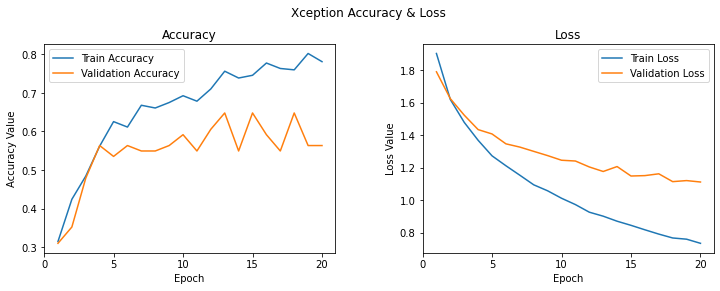

In [88]:
plot_accuracy_loss_for_train_valid(Xception_history, "Xception Accuracy & Loss")

Load the Best Xception weights from training

In [89]:
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

Get the accuracy for the model

In [90]:
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(y_test, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 58.8235%


In [91]:
Xception_test_score = Xception_model.evaluate(test_Xception,y_test)
print("Log loss of the Xception model is {0}".format(Xception_test_score[0]))

3/3 [==============================] - 0s 10ms/step - loss: 1.1586 - accuracy: 0.5882
Log loss of the Xception model is 1.1586138010025024


Normalized confusion matrix


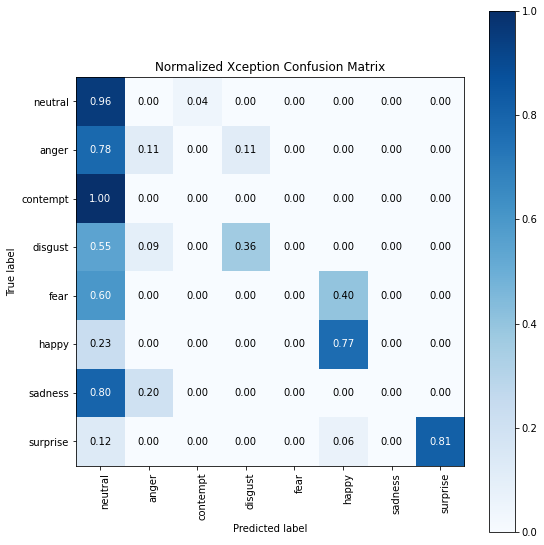

In [92]:
plot_confusion_matrix(test_df.emotion, Xception_predictions, classes=emotions, normalize=True,
                      title='Normalized Xception Confusion Matrix')

plt.show()

Load the input for Augumented VGG16 model

In [93]:
def get_aug_input_features(img_paths):
    list_of_tensors = [path_to_tensor(img_path, None, None, transfer_learn=False) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [94]:
train_aug_tensors_VGG = get_aug_input_features(train_files)
valid_aug_tensors_VGG = get_aug_input_features(valid_files)
test_aug_tensors_VGG = get_aug_input_features(test_files)










  0%|          | 0/283 [00:00<?, ?it/s]








  5%|▍         | 13/283 [00:00<00:02, 124.67it/s]








 10%|▉         | 28/283 [00:00<00:01, 130.41it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










 14%|█▍        | 41/283 [00:00<00:01, 129.22it/s]








 20%|██        | 57/283 [00:00<00:01, 135.78it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










 26%|██▌       | 73/283 [00:00<00:01, 140.32it/s]








 31%|███       | 87/283 [00:00<00:01, 140.16it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










 36%|███▌      | 101/283 [00:00<00:01, 138.87it/s]








 41%|████      | 116/283 [00:00<00:01, 141.38it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










 46%|████▌     | 130/283 [00:00<00:01, 131.56it/s]








 51%|█████     | 145/283 [00:01<00:01, 135.61it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










 57%|█████▋    | 160/283 [00:01<00:00, 139.10it/s]








 61%|██████▏   | 174/283 [00:01<00:00, 136.60it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










 66%|██████▋   | 188/283 [00:01<00:00, 136.94it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










 71%|███████▏  | 202/283 [00:01<00:00, 126.45it/s]








 76%|███████▋  | 216/283 [00:01<00:00, 127.69it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










 81%|████████▏ | 230/283 [00:01<00:00, 128.90it/s]








 86%|████████▌ | 243/283 [00:01<00:00, 121.89it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










 90%|█████████ | 256/283 [00:01<00:00, 119.89it/s]








 95%|█████████▌| 269/283 [00:02<00:00, 120.64it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










100%|██████████| 283/283 [00:02<00:00, 129.98it/s]


image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)











  0%|          | 0/71 [00:00<?, ?it/s]








 30%|██▉       | 21/71 [00:00<00:00, 203.65it/s]








 56%|█████▋    | 40/71 [00:00<00:00, 198.87it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










100%|██████████| 71/71 [00:00<00:00, 188.06it/s]









  0%|          | 0/85 [00:00<?, ?it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










 24%|██▎       | 20/85 [00:00<00:00, 194.71it/s]








 46%|████▌     | 39/85 [00:00<00:00, 192.59it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to










 67%|██████▋   | 57/85 [00:00<00:00, 187.94it/s]








 89%|████████▉ | 76/85 [00:00<00:00, 187.42it/s]

image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to

100%|██████████| 85/85 [00:00<00:00, 177.77it/s]


image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)
image.img_to_array(img) =  (350, 350, 3)
np.expand_dims =  (1, 350, 350, 3)


In [95]:
train_aug_tensors_VGG.shape

(283, 350, 350, 3)

In [96]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
    )

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_aug_tensors_VGG, y_train, batch_size=32)
val_generator = val_datagen.flow(valid_aug_tensors_VGG, y_valid, batch_size=71)

In [97]:
# https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
vgg_aug = VGG16(include_top=False, weights='imagenet', 
                                     input_shape=(350,350,3))

vgg_aug_output = vgg_aug.layers[-1].output
#vgg_aug_output = keras.layers.Flatten()(vgg_aug_output)
vgg_aug_model = Model(vgg_aug.input, vgg_aug_output)

vgg_aug_model.trainable = False
for layer in vgg_aug_model.layers:
    layer.trainable = False

pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_aug_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  del sys.path[0]


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f74513f56d0>,input_4,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74513f55d0>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74535b8090>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f74513f5110>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7453753d10>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74535b8410>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f745337cc50>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f74514b4450>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7453368990>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7453367d10>,block3_conv3,False


In [98]:
input_shape = vgg_aug_model.output_shape[1:]

model_vgg_aug = Sequential()
model_vgg_aug.add(vgg_aug_model)
model_vgg_aug.add(GlobalAveragePooling2D(input_shape=input_shape))
model_vgg_aug.add(Dense(8, activation='sigmoid'))

model_vgg_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 10, 10, 512)       14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 4104      
Total params: 14,718,792
Trainable params: 4,104
Non-trainable params: 14,714,688
_________________________________________________________________


In [99]:
model_vgg_aug.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [100]:
train_steps_per_epoch_vgg = train_aug_tensors_VGG.shape[0]//32
val_steps_per_epoch_vgg = valid_aug_tensors_VGG.shape[0]//71
print(train_steps_per_epoch_vgg, val_steps_per_epoch_vgg)

8 1


In [101]:

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
model_vgg_aug_checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.vgg_aug.hdf5',
                               verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model_vgg_aug_history = model_vgg_aug.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch_vgg, epochs=10,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch_vgg, callbacks=[model_vgg_aug_checkpointer, early_stop, reduce_lr],
                              verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
8/8 [==============================] - 225s 29s/step - loss: 5.6169 - accuracy: 0.0991 - val_loss: 3.6245 - val_accuracy: 0.1127

Epoch 00001: val_loss improved from inf to 3.62446, saving model to saved_models/weights.best.vgg_aug.hdf5
Epoch 2/10
8/8 [==============================] - 223s 29s/step - loss: 3.5529 - accuracy: 0.1741 - val_loss: 3.2583 - val_accuracy: 0.1690

Epoch 00002: val_loss improved from 3.62446 to 3.25827, saving model to saved_models/weights.best.vgg_aug.hdf5
Epoch 3/10
8/8 [==============================] - 224s 29s/step - loss: 2.7835 - accuracy: 0.2661 - val_loss: 2.8241 - val_accuracy: 0.1972

Epoch 00003: val_loss improved from 3.25827 to 2.82414, saving model to saved_models/weights.best.vgg_aug.hdf5
Epoch 4/10
8/8 [==============================] - 223s 29s/step - loss: 2.4494 - accuracy: 0.2423 - val_loss: 2.4932 - val_accuracy: 0.2817

Epoch 00004: val_loss improved from 2.82414 to 2.49319, saving model to saved_models/weights.best.vgg_aug.h

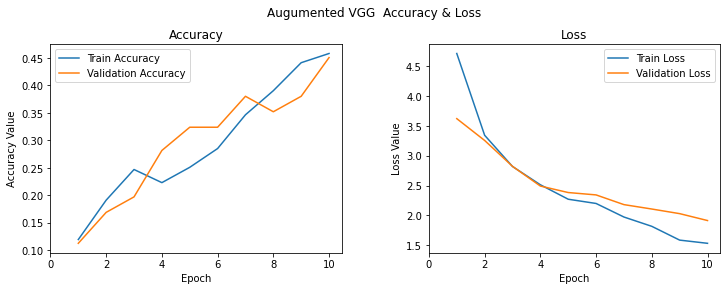

In [102]:
# epoch len depends on # of epochs that got trained. Print and see model_vgg_aug_history.history
plot_accuracy_loss_for_train_valid(model_vgg_aug_history, "Augumented VGG  Accuracy & Loss", epoch_len=11, epoch_window=2)

Load the Best Augumented VGG16 weights from training


In [103]:
model_vgg_aug.load_weights('saved_models/weights.best.vgg_aug.hdf5')

Get the accuracy for the model


In [104]:
model_vgg_aug_predictions = [np.argmax(model_vgg_aug.predict(np.expand_dims(feature, axis=0))) for feature in test_aug_tensors_VGG]

# report test accuracy
test_accuracy = 100*np.sum(np.array(model_vgg_aug_predictions)==np.argmax(y_test, axis=1))/len(model_vgg_aug_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 32.9412%


In [105]:
vgg_aug_test_score = model_vgg_aug.evaluate(test_aug_tensors_VGG,y_test)
print("Log loss of the Xception model is {0}".format(vgg_aug_test_score[0]))

3/3 [==============================] - 57s 18s/step - loss: 2.0198 - accuracy: 0.3294
Log loss of the Xception model is 2.019808769226074


Normalized confusion matrix


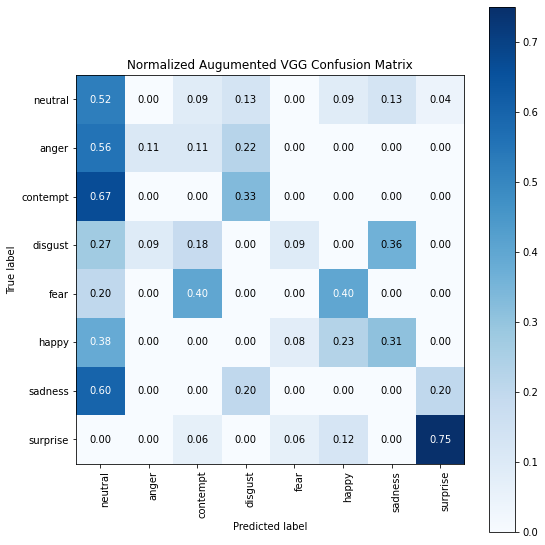

In [106]:
plot_confusion_matrix(test_df.emotion, model_vgg_aug_predictions, classes=emotions, normalize=True,
                      title='Normalized Augumented VGG Confusion Matrix')

plt.show()